 ## Imports

In [43]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import Lambda, ToTensor

## Load dataset

In [44]:
df = pd.read_csv('in-vehicle-coupon-recommendation.csv')
display(list(df.columns.values))
df.rename(columns={"passanger": "passenger"}, inplace=True)
df

['destination',
 'passanger',
 'weather',
 'temperature',
 'time',
 'coupon',
 'expiration',
 'gender',
 'age',
 'maritalStatus',
 'has_children',
 'education',
 'occupation',
 'income',
 'car',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50',
 'toCoupon_GEQ5min',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_same',
 'direction_opp',
 'Y']

,destination,passenger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


## Fill missing values in data
- Count NAs per column
- Make a list of columns containing NAs
- Do not list columns containing more than 50% NAs<br>(insufficient data for replacement)
- Replace NAs with mode in all listed columns

(only to be used for categorical features,<br>numerical ones would require selecting the mean)

In [45]:
df.isna().sum()

destination                 0
passenger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

In [46]:
columns_withNA = []

for index, value in df.isna().sum().items():
    if value>0 and value < (df.shape[0] / 2):
        columns_withNA.append(index)
print(columns_withNA)

for column in columns_withNA:
    print('Column is: ' + column)
    print('Mode is: ' + df[column].mode()[0])
    print()
    df[column] = df[column].fillna( df[column].mode()[0])

df.isna().sum()

['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
Column is: Bar
Mode is: never

Column is: CoffeeHouse
Mode is: less1

Column is: CarryAway
Mode is: 1~3

Column is: RestaurantLessThan20
Mode is: 1~3

Column is: Restaurant20To50
Mode is: less1



destination                 0
passenger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                         0
CoffeeHouse                 0
CarryAway                   0
RestaurantLessThan20        0
Restaurant20To50            0
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

<AxesSubplot:ylabel='Y'>

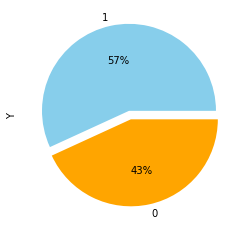

In [47]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
df.Y.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

## Data Preprocessing
- make a list of all categorical features
- mark categorical features in df
- get an overview of occurring values
- drop irrelevant features
- encode categories to integer
- convert to tensors

In [48]:
df.dtypes

destination             object
passenger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
car                     object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ5min         int64
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
direction_opp            int64
Y                        int64
dtype: object

In [49]:
categorical_columns = df.columns.drop(labels=['temperature', 'Y'])
numerical_columns = ['temperature']
outputs = ['Y']

In [50]:
for feature in categorical_columns:
    df[feature] = df[feature].astype('category')
    print('Current feature: ' + feature)
    valueArray = df[feature].value_counts(dropna=False).index
    for value in valueArray:
        print(value)
    print()

categorical_columns = categorical_columns.drop(labels=['car', 'toCoupon_GEQ5min']) # useless feature
df = df.drop(labels=['car', 'toCoupon_GEQ5min'], axis=1)
print(categorical_columns)

Current feature: destination
No Urgent Place
Home
Work

Current feature: passenger
Alone
Friend(s)
Partner
Kid(s)

Current feature: weather
Sunny
Snowy
Rainy

Current feature: time
6PM
7AM
10AM
2PM
10PM

Current feature: coupon
Coffee House
Restaurant(<20)
Carry out & Take away
Bar
Restaurant(20-50)

Current feature: expiration
1d
2h

Current feature: gender
Female
Male

Current feature: age
21
26
31
50plus
36
41
46
below21

Current feature: maritalStatus
Married partner
Single
Unmarried partner
Divorced
Widowed

Current feature: has_children
0
1

Current feature: education
Some college - no degree
Bachelors degree
Graduate degree (Masters or Doctorate)
Associates degree
High School Graduate
Some High School

Current feature: occupation
Unemployed
Student
Computer & Mathematical
Sales & Related
Education&Training&Library
Management
Office & Administrative Support
Arts Design Entertainment Sports & Media
Business & Financial
Retired
Food Preparation & Serving Related
Healthcare Practiti

In [51]:
df.head()

,destination,passenger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,never,1~3,4~8,1~3,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,never,1~3,4~8,1~3,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,never,1~3,4~8,1~3,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,never,1~3,4~8,1~3,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,never,1~3,4~8,1~3,1,0,0,1,0


In [52]:
categorical_data = np.stack([df[feature].cat.codes.values for feature in categorical_columns], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.float)
categorical_data[:5]

tensor([[ 1.,  0.,  2.,  2.,  4.,  0.,  0.,  0.,  3.,  1.,  5., 24.,  3.,  4.,
          4.,  0.,  1.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  1.,  2.,  0.,  2.,  1.,  0.,  0.,  3.,  1.,  5., 24.,  3.,  4.,
          4.,  0.,  1.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  1.,  2.,  0.,  1.,  1.,  0.,  0.,  3.,  1.,  5., 24.,  3.,  4.,
          4.,  0.,  1.,  0.,  1.,  0.,  0.,  1.],
        [ 1.,  1.,  2.,  2.,  2.,  1.,  0.,  0.,  3.,  1.,  5., 24.,  3.,  4.,
          4.,  0.,  1.,  0.,  1.,  0.,  0.,  1.],
        [ 1.,  1.,  2.,  2.,  2.,  0.,  0.,  0.,  3.,  1.,  5., 24.,  3.,  4.,
          4.,  0.,  1.,  0.,  1.,  0.,  0.,  1.]])

In [53]:
numerical_data = np.stack([df[feature].values for feature in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)
numerical_data[:5]

tensor([[55.],
        [80.],
        [80.],
        [80.],
        [80.]])

In [54]:
outputs = torch.tensor(df[outputs].values, dtype=torch.float).flatten()
outputs[:5]

tensor([1., 0., 1., 0., 0.])

In [55]:
print(categorical_data.shape)
print(numerical_data.shape)
print(outputs.shape)

torch.Size([12684, 22])
torch.Size([12684, 1])
torch.Size([12684])


In [56]:
categorical_columns_sizes = [len(df[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_columns_sizes]
print(categorical_embedding_sizes)

[(3, 2), (4, 2), (3, 2), (5, 3), (5, 3), (2, 1), (2, 1), (8, 4), (5, 3), (2, 1), (6, 3), (25, 13), (9, 5), (5, 3), (5, 3), (5, 3), (5, 3), (5, 3), (2, 1), (2, 1), (2, 1), (2, 1)]


## Train-Test-Split

In [57]:
total_records = outputs.shape[0]
test_records = int(total_records * .25)

categorical_train_data = categorical_data[:total_records-test_records]
categorical_test_data = categorical_data[total_records-test_records:total_records]

numerical_train_data = numerical_data[:total_records-test_records]
numerical_test_data = numerical_data[total_records-test_records:total_records]

train_outputs = outputs[:total_records-test_records]
test_outputs = outputs[total_records-test_records:total_records]

print(len(categorical_train_data))
print(len(numerical_train_data))
print(len(train_outputs))

print(len(categorical_test_data))
print(len(numerical_test_data))
print(len(test_outputs))

9513
9513
9513
3171
3171
3171


#### Check if Cuda is supported

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))



categorical_train_data = torch.Tensor(categorical_train_data).long().to(device)
categorical_test_data = torch.Tensor(categorical_test_data).long().to(device)

numerical_train_data = torch.Tensor(numerical_train_data).float().to(device)
numerical_test_data = torch.Tensor(numerical_test_data).float().to(device)

train_outputs = torch.Tensor(train_outputs).long().to(device)
test_outputs = torch.Tensor(test_outputs).long().to(device)

Using cuda device


#### Build the NN
- initialize model
- set loss function and optimizer

In [59]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

In [60]:
model = Model(categorical_embedding_sizes, numerical_data.shape[1], 2, [200, 100, 50], p=0.4).to(device)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(4, 2)
    (2): Embedding(3, 2)
    (3): Embedding(5, 3)
    (4): Embedding(5, 3)
    (5): Embedding(2, 1)
    (6): Embedding(2, 1)
    (7): Embedding(8, 4)
    (8): Embedding(5, 3)
    (9): Embedding(2, 1)
    (10): Embedding(6, 3)
    (11): Embedding(25, 13)
    (12): Embedding(9, 5)
    (13): Embedding(5, 3)
    (14): Embedding(5, 3)
    (15): Embedding(5, 3)
    (16): Embedding(5, 3)
    (17): Embedding(5, 3)
    (18): Embedding(2, 1)
    (19): Embedding(2, 1)
    (20): Embedding(2, 1)
    (21): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=63, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)

In [61]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model

epoch:   0 loss: 0.86927736
epoch: 200 loss: 0.63307065
epoch: 400 loss: 0.59146070
epoch: 600 loss: 0.56845891
epoch: 800 loss: 0.54902434
epoch: 1000 loss: 0.53799349
epoch: 1200 loss: 0.52926928
epoch: 1400 loss: 0.52108461
epoch: 1600 loss: 0.50868797
epoch: 1800 loss: 0.50735259
epoch: 2000 loss: 0.49796474
epoch: 2200 loss: 0.49445039
epoch: 2400 loss: 0.48825160
epoch: 2600 loss: 0.48091105
epoch: 2800 loss: 0.48584178
epoch: 3000 loss: 0.47545695
epoch: 3200 loss: 0.47487074
epoch: 3400 loss: 0.47027248
epoch: 3600 loss: 0.47295386
epoch: 3800 loss: 0.46689147
epoch: 4000 loss: 0.47404784
epoch: 4200 loss: 0.46608084
epoch: 4400 loss: 0.46655020
epoch: 4600 loss: 0.46121600
epoch: 4800 loss: 0.46219575
epoch: 5000 loss: 0.46368590
epoch: 5200 loss: 0.46301094
epoch: 5400 loss: 0.44884643
epoch: 5600 loss: 0.45447493
epoch: 5800 loss: 0.45783883
epoch: 6000 loss: 0.46231699
epoch: 6200 loss: 0.45873976
epoch: 6400 loss: 0.45185247
epoch: 6600 loss: 0.45217893
epoch: 6800 loss: 0

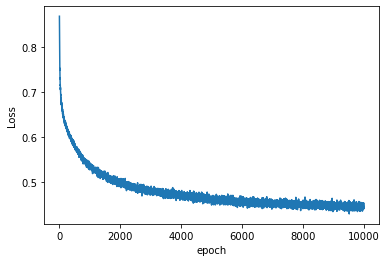

In [62]:
epochs = 10000
aggregated_losses = []

for i in range(epochs):

    y_pred = model(categorical_train_data, numerical_train_data)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i%200 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

In [63]:
with torch.no_grad():
    y_val = model(categorical_test_data, numerical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.82202864


In [64]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

_, predicted = torch.max(y_val.data, 1)
predicted_cpu = predicted.to('cpu')
test_outputs_cpu = test_outputs.to('cpu')

print(confusion_matrix(test_outputs_cpu,predicted_cpu))
print(classification_report(test_outputs_cpu,predicted_cpu))
print(f'Accuracy Score: {accuracy_score(test_outputs_cpu, predicted_cpu)}')

[[ 800  600]
 [ 570 1201]]
              precision    recall  f1-score   support

           0       0.58      0.57      0.58      1400
           1       0.67      0.68      0.67      1771

    accuracy                           0.63      3171
   macro avg       0.63      0.62      0.63      3171
weighted avg       0.63      0.63      0.63      3171

Accuracy Score: 0.631031220435194
